### AE4465 (MM&A) - Lecture5 (IMS Bearings Case Study)

Four bearings were installed on a shaft. The rotation speed was kept constant at 2000 RPM by an AC motor coupled to the shaft via rub belts. A radial load of 6000 lbs is applied onto the shaft and bearing by a spring mechanism. All bearings are force lubricated.

Rexnord ZA-2115 double row bearings were installed on the shaft as shown in Figure 1. PCB 353B33 High Sensitivity Quartz ICP accelerometers were installed on the bearing housing (two accelerometers for each bearing [x- and y-axes] for data set 1, one accelerometer for each bearing for data sets 2 and 3). Sensor placement is also shown in Figure 1. All failures occurred after exceeding designed lifetime of the bearing which is more than 100 million revolutions.

 &nbsp;
<center><img top-margin="10px" alt="Bearings installation" src="imgs\bearings.png" width="700"/></center>

Three (3) data sets are included in the data packet (IMS-Rexnord Bearing Data.zip). Each data set describes a test-to-failure experiment. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point. Data collection was facilitated by NI DAQ Card 6062E. Larger intervals of time stamps (showed in file names) indicate resumption of the experiment in the next working day.


**Set No. 1**

| Index                    | Description                                                                                                                   |
|--------------------------|-------------------------------------------------------------------------------------------------------------------------------|
| Recording Duration:      | October 22, 2003 12:06:24 to November 25, 2003 23:39:56                                                                       |
| No. of Files:            | 2,156                                                                                                                         |
| No. of Channels:         | 8                                                                                                                             |
| Channel Arrangement:     | Bearing 1 – Ch 1&2; Bearing 2 – Ch 3&4; Bearing 3 – Ch 5&6; Bearing 4 – Ch 7&8.                                               |
| File Recording Interval: | Every 10 minutes (except the first 43 files were taken every 5 minutes)                                                       |
| File Format:             | ASCII                                                                                                                         |
| Description:             | At the end of the test-to-failure experiment, inner race defect occurred in bearing 3 and roller element defect in bearing 4. |

**Set No. 2**

| Index                    | Description                                                                             |
|--------------------------|-----------------------------------------------------------------------------------------|
| Recording Duration:      | February 12, 2004 10:32:39 to February 19, 2004 06:22:39                                |
| No. of Files:            | 984                                                                                     |
| No. of Channels:         | 4                                                                                       |
| Channel Arrangement:     | Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.                    |
| File Recording Interval: | Every 10 minutes                                                                        |
| File Format:             | ASCII                                                                                   |
| Description:             | At the end of the test-to-failure experiment, outer race failure occurred in bearing 1. |

**Set No. 3**

| Index                    | Description                                                                             |
|--------------------------|-----------------------------------------------------------------------------------------|
| Recording Duration:      | March 4, 2004 09:27:46 to April 4, 2004 19:01:57                                        |
| No. of Files:            | 4,448                                                                                   |
| No. of Channels:         | 4                                                                                       |
| Channel Arrangement:     | Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.                    |
| File Recording Interval: | Every 10 minutes                                                                        |
| File Format:             | ASCII                                                                                   |
| Description:             | At the end of the test-to-failure experiment, outer race failure occurred in bearing 3. |


In [1]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats
# Though the following import is not directly being used, it is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
from scipy.special import entr
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [8]:
# Import the data in one of the csv file
dataset_path_1st = 'data/IMSBearings/1st_test/1st_test'
dataset_path_2nd = 'data/IMSBearings/2nd_test/2nd_test'
dataset_path_3rd = 'data/IMSBearings/3rd_test/4th_test/txt'

# Test for the first file
dataset = pd.read_csv('data/IMSBearings/1st_test/1st_test/2003.10.22.12.06.24', sep='\t')
dataset.columns = ['Bearing 1a','Bearing 1b','Bearing 2a','Bearing 2b', 'Bearing 3a', 'Bearing 3b', 'Bearing 4a', 'Bearing 4b']
dataset.head()

,Bearing 1a,Bearing 1b,Bearing 2a,Bearing 2b,Bearing 3a,Bearing 3b,Bearing 4a,Bearing 4b
0,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
1,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
2,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
3,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066
4,-0.232,-0.061,-0.281,-0.125,0.046,-0.088,-0.078,-0.078


### Analysis of starting vibration of bearing 1

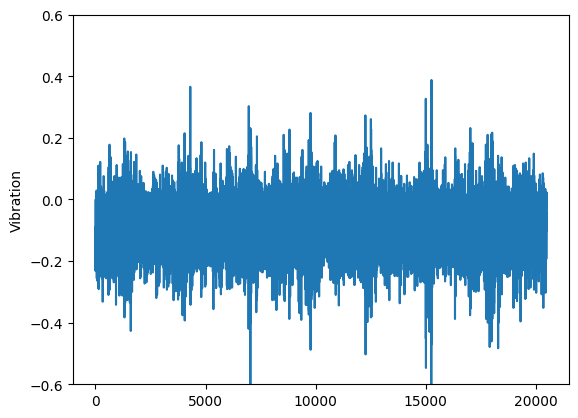

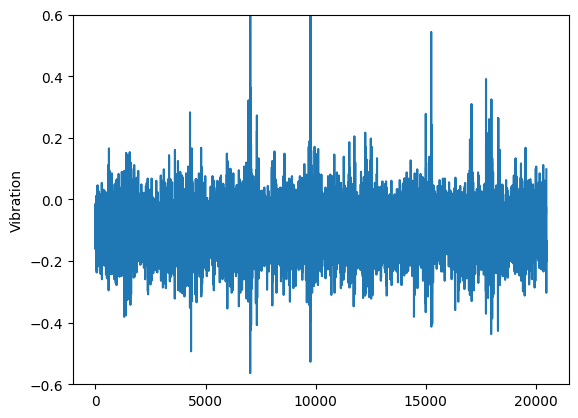

In [11]:
# plot the raw signal at the beginning of bearing 1
plt.plot(dataset[['Bearing 1a']])
plt.ylabel('Vibration')
plt.ylim((-0.6, 0.6))
plt.show()
plt.plot(dataset[['Bearing 1b']])
plt.ylabel('Vibration')
plt.ylim((-0.6, 0.6))
plt.show()

### Analysis of the entire trajectory of bearing 1

It is possible to analyze the entire trajectory until the end of life of the equipment.

In [16]:
# extract function
def merge_data(dataset_path, id_set=None):
    data = pd.DataFrame()
    for filename in os.listdir(dataset_path):
        dataset=pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        dataset_mean_abs = np.array(dataset.abs().mean())
        if id_set == 1:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,8))
        else:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
        dataset_mean_abs.index = [filename]
        data = data.append(dataset_mean_abs)

    if id_set == 1:
        data.columns = ['B1_a','B1_b','B2_a','B2_b','B3_a','B3_b','B4_a','B4_b']
    else:
        data.columns = ['B1','B2','B3','B4']

    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

### Extract the mean value of each value until the end-of-life

It is also possible to analyze the trajectories of the same bearing to check visually.


C:\Users\Owner\AppData\Local\Temp\ipykernel_11160\1583490302.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset_mean_abs)
C:\Users\Owner\AppData\Local\Temp\ipykernel_11160\1583490302.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset_mean_abs)
C:\Users\Owner\AppData\Local\Temp\ipykernel_11160\1583490302.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset_mean_abs)
C:\Users\Owner\AppData\Local\Temp\ipykernel_11160\1583490302.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset_mean_abs)
C:\Users\Owner\AppData\Local\Temp\ipyker

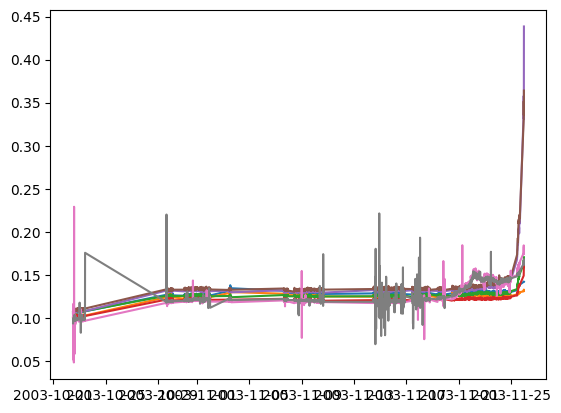

C:\Users\Owner\AppData\Local\Temp\ipykernel_11160\3657812339.py:12: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pd.concat(data, dataset_mean_abs)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [ ]:
dt = merge_data(dataset_path_1st, id_set=1)

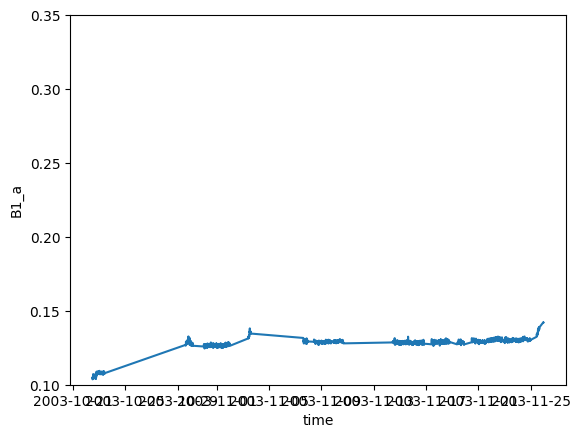

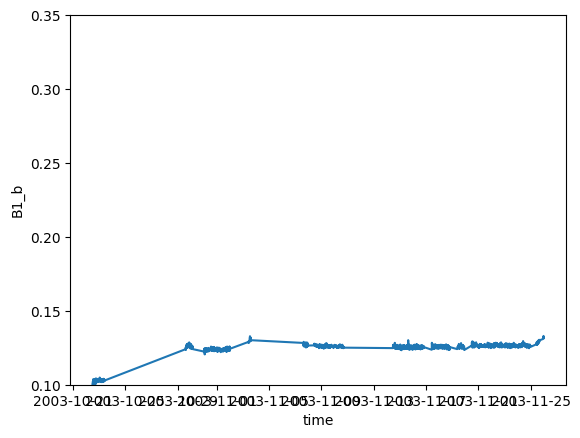

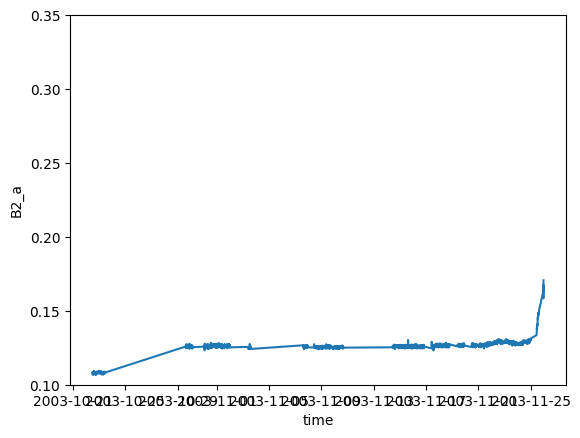

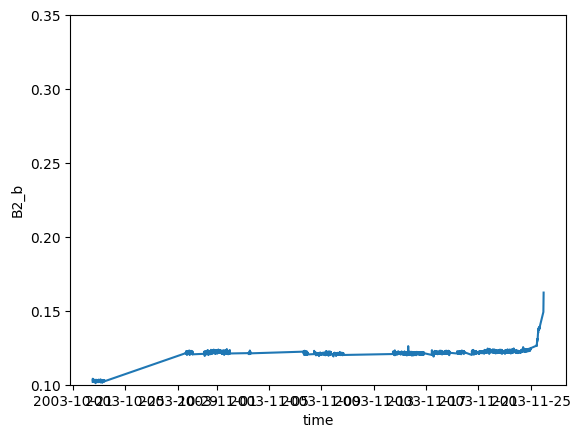

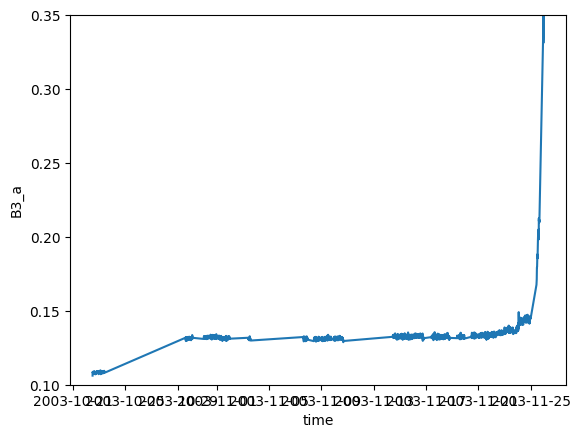

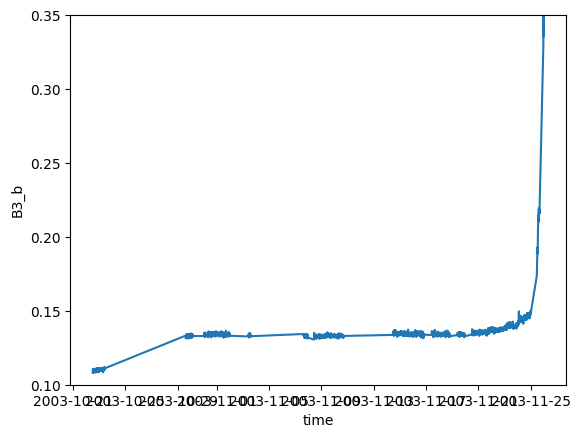

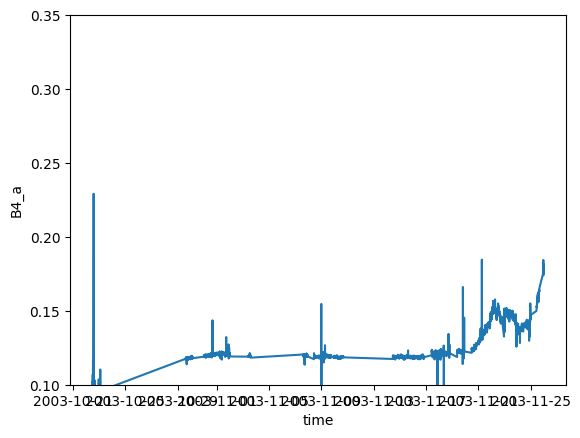

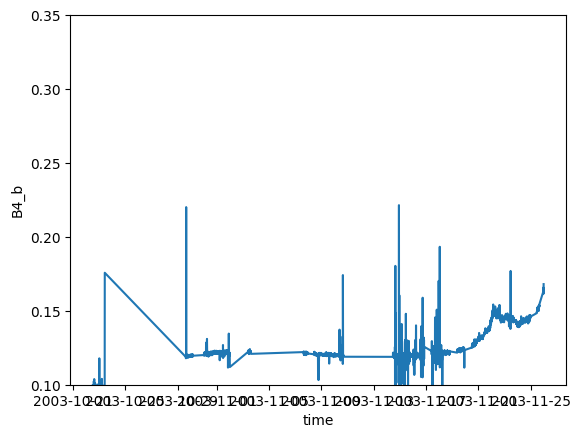

In [19]:
for col in dt.columns:
    plt.plot(dt[col])
    plt.ylabel(col)
    plt.xlabel('time')
    plt.ylim((0.1, 0.35))
    plt.show()